In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

import astropy
from astroquery.gaia import Gaia

from pyts.image import GramianAngularField

from fastcore.all import *
from fastai.vision.all import *

In [18]:
# Create and save a GADF image


def GADF_image(product, ID, var_type):
    df = product[["phase", "mag", "band"]].to_pandas()
    df.dropna(inplace=True)

    phase = df["phase"].to_numpy().reshape(1, -1)

    X = df["mag"].to_numpy().reshape(1, -1)

    # df_g = df[df["band"] == "G"][["phase", "mag"]]
    # phase_g = df_g["phase"].to_numpy().reshape(1, -1)
    # X_g = df_g["mag"].to_numpy().reshape(1, -1)
    # phase = phase_g
    # X = X_g

    gadf = GramianAngularField(method="difference")

    try:
        X_gadf = gadf.fit_transform(X)

        fig = plt.figure(frameon=False)
        fig.set_size_inches(4, 4)

        ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
        ax.set_axis_off()
        fig.add_axes(ax)

        ax.imshow(X_gadf[0], cmap="rainbow")
        fig.savefig(f"data/{var_type}/{ID}.png", bbox_inches="tight")
        plt.close(fig)
    except ValueError as err:
        print(f"Error in {var_type} {ID} \n {err=}, {type(err)=}")

In [24]:
var_type_list = ["cepheid", "rr_lyrae"]
n_stars = 5000

path = Path("data")

for o in var_type_list:
    dest = path / o
    dest.mkdir(exist_ok=True, parents=True)

for var_type in var_type_list:
    if var_type == "cepheid":
        query = f"SELECT TOP {n_stars} source_id, pf, p1_o, p2_o, epoch_g \
            FROM gaiadr3.vari_cepheid"
    elif var_type == "rr_lyrae":
        query = f"SELECT TOP {n_stars} source_id, pf, p1_o, epoch_g \
            FROM gaiadr3.vari_rrlyrae"

    job = Gaia.launch_job_async(query)
    results = job.get_results()

    df_results = results.to_pandas()
    # Replace missing periods with the period of the first overtone
    df_results["pf"] = df_results["pf"].fillna(df_results["p1_o"])

    retrieval_type = "EPOCH_PHOTOMETRY"  # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
    data_structure = "INDIVIDUAL"  # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
    data_release = "Gaia DR3"  # Options are: 'Gaia DR3' (default), 'Gaia DR2'

    # Cepheid
    datalink = Gaia.load_data(
        ids=df_results["SOURCE_ID"],
        data_release=data_release,
        retrieval_type=retrieval_type,
        data_structure=data_structure,
        verbose=False,
        output_file=None,
        format="csv",
    )

    for ID in df_results["SOURCE_ID"]:
        # Define the period corresponding to the fundamental pulsation mode
        period_f = df_results[df_results["SOURCE_ID"] == ID]["pf"].values[0]
        # Define the arbitrary start point of the phase, epoch of the maximum of the light curve in the G band
        epoch_g = df_results[df_results["SOURCE_ID"] == ID]["epoch_g"].values[0]

        dl_key = f"EPOCH_PHOTOMETRY-Gaia DR3 {ID}.csv"

        product = datalink[dl_key][0]
        product["phase"] = (product["time"] - epoch_g) % period_f

        GADF_image(product, ID, var_type)

INFO: Query finished. [astroquery.utils.tap.core]


Error in cepheid 5278444889019947136 
 err=ValueError('Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.'), type(err)=<class 'ValueError'>
Error in cepheid 4663679728599261824 
 err=ValueError('Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.'), type(err)=<class 'ValueError'>
Error in cepheid 4663699038757253376 
 err=ValueError('Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.'), type(err)=<class 'ValueError'>
Error in cepheid 4663786346849472000 
 err=ValueError('Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.'), type(err)=<class 'ValueError'>
Error in cepheid 5265845860154530304 
 err=ValueError('Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.'), type(err)=<class 'ValueError'>
Error in cepheid 4654679122130157952 
 err=ValueError('Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.'), type(err)=<class 'Value

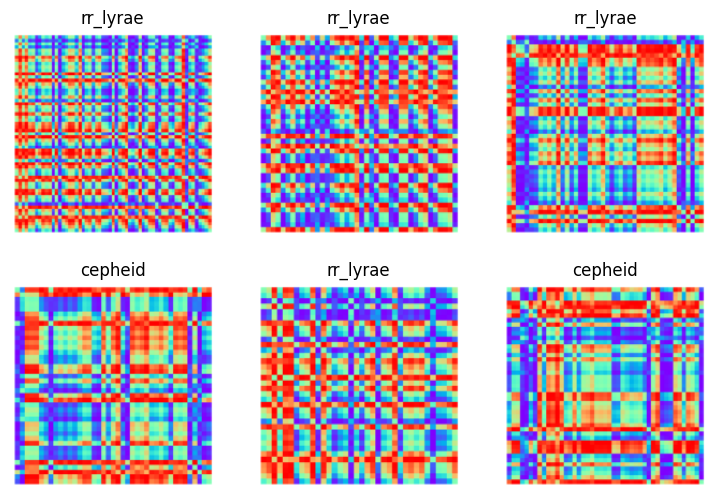

In [25]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    # Inputs for our model are images, outputs are categories (bird or forest)
    get_items=get_image_files,
    # Returns a list of all images in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Split the data into training and validation sets, using 20% for validation
    get_y=parent_label,
    # The label for each image is the name of the folder it's in
    item_tfms=[Resize(192, method="squish")],
    # Resize each image to 192x192 pixels by squishing instead of cropping
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [26]:
# Set seed, try different resnets

learn = vision_learner(dls, resnet34, metrics=error_rate)
# Create a model using the data in `dls`, using the ResNet18 architecture
learn.fine_tune(3)
# Fine-tune the model for 3 epochs

epoch,train_loss,valid_loss,error_rate,time
0,0.709255,0.550222,0.260891,05:55


epoch,train_loss,valid_loss,error_rate,time
0,0.489051,0.399131,0.184777,06:44
1,0.306432,0.354483,0.153731,06:45
2,0.106034,0.364928,0.129695,06:51


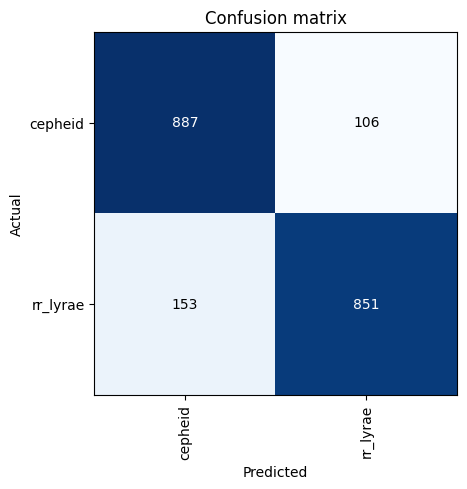

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

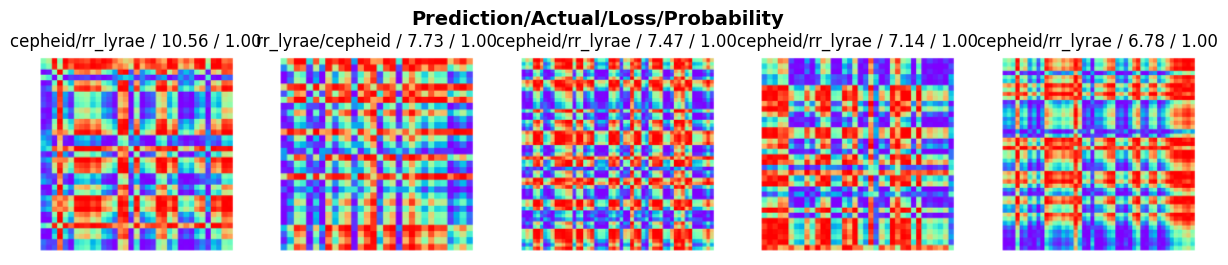

In [28]:
interp.plot_top_losses(5, nrows=1)